In [48]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Random
using BenchmarkTools

In [49]:
@model [ outbound_message_portal = EmptyPortal() ] function gaussian_mixture_model(n)
    
    s ~ Beta(1.0, 1.0)
    
    m1 ~ NormalMeanVariance(0.0, 100.0)
    w1 ~ Gamma(0.01, 100.0)
    
    m2 ~ NormalMeanVariance(0.0, 100.0)
    w2 ~ Gamma(0.01, 100.0)
    
    z = randomvar(n)
    y = datavar(Float64, n)
    
    for i in 1:n
        z[i] ~ Bernoulli(s) where { q = MeanField() }
        y[i] ~ NormalMixture(z[i], (m1, m2), (w1, w2)) where { q = MeanField() }
    end
    
    return s, m1, w1, m2, w2, z, y
end

gaussian_mixture_model (generic function with 1 method)

In [50]:
using Random

In [68]:
function inference(data)
    n = length(data)
    model, (s, m1, w1, m2, w2, z, y) = gaussian_mixture_model(n);
    
    mswitch = Vector{Marginal}()
    mm1 = Vector{Marginal}()
    mm2 = Vector{Marginal}()
    mw1 = Vector{Marginal}()
    mw2 = Vector{Marginal}()
    
    fe = Vector{Float64}()
    
    fe_scheduler = PendingScheduler()
    
    m1sub = subscribe!(getmarginal(m1), (ms) -> push!(mm1, ms))
    m2sub = subscribe!(getmarginal(m2), (ms) -> push!(mm2, ms))
    w1sub = subscribe!(getmarginal(w1), (ms) -> push!(mw1, ms))
    w2sub = subscribe!(getmarginal(w2), (ms) -> push!(mw2, ms))
    switchsub = subscribe!(getmarginal(s), (ms) -> push!(mswitch, ms))
    
    fesub = subscribe!(score(BetheFreeEnergy(), model, fe_scheduler), (f) -> push!(fe, f))
    
    setmarginal!(s, vague(Beta))
    setmarginal!(m1, NormalMeanVariance(-1.0, 1e4))
    setmarginal!(m2, NormalMeanVariance(2.0, 1e4))
    setmarginal!(w1, vague(Gamma))
    setmarginal!(w2, vague(Gamma))
    
    for i in 1:20
        update!(y, data)
        release!(fe_scheduler)
    end
    
    unsubscribe!(fesub)
    unsubscribe!(switchsub)
    unsubscribe!(m1sub)
    unsubscribe!(m2sub)
    unsubscribe!(w1sub)
    unsubscribe!(w2sub)
    
    return mswitch, mm1[5:end], mm2[5:end], mw1[5:end], mw2[5:end], fe
end

inference (generic function with 1 method)

In [69]:
n = 1500

Random.seed!(124)

switch = 0.23
z      = rand(n) .< switch
y      = Vector{Float64}(undef, n)

μ1 = -2.0
μ2 = +2.0
w  = 1.7777

d1 = Normal(μ1, sqrt(inv(w)))
d2 = Normal(μ2, sqrt(inv(w)))

for i in 1:n
    y[i] = z[i] ? rand(d1) : rand(d2)
end

In [73]:
@time mswitch, mm1, mm2, mw1, mw2, fe = inference(y);

  3.288654 seconds (9.87 M allocations: 485.622 MiB, 15.39% gc time)


In [74]:
using Plots

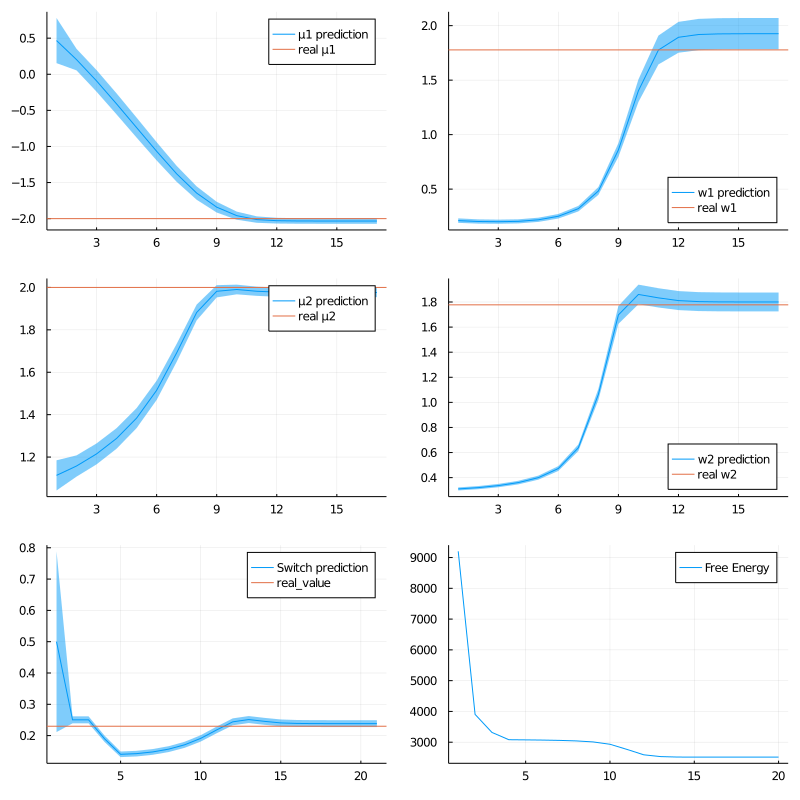

In [75]:
m1p = plot(mean.(mm1), ribbon = var.(mm1) .|> sqrt, label = "μ1 prediction")
m1p = plot!(m1p, [ μ1 ], seriestype = :hline, label = "real μ1")

w1p = plot(mean.(mw1), ribbon = var.(mw1) .|> sqrt, label = "w1 prediction", legend = :bottomright)
w1p = plot!(w1p, [ w ], seriestype = :hline, label = "real w1")

m2p = plot(mean.(mm2), ribbon = var.(mm2) .|> sqrt, label = "μ2 prediction")
m2p = plot!(m2p, [ μ2 ], seriestype = :hline, label = "real μ2")

w2p = plot(mean.(mw2), ribbon = var.(mw2) .|> sqrt, label = "w2 prediction", legend = :bottomright)
w2p = plot!(w2p, [ w ], seriestype = :hline, label = "real w2")

swp = plot(mean.(mswitch), ribbon = var.(mswitch) .|> sqrt, label = "Switch prediction")
swp = plot!(swp, [ switch ], seriestype = :hline, label = "real_value")

fep = plot(fe, label = "Free Energy")

plot(m1p, w1p, m2p, w2p, swp, fep, layout = @layout([ a b; c d ; e f ]), size = (800, 800))